In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
from configparser import ConfigParser

import numpy as np
import torch
from easydict import EasyDict
from pytorch_lightning import seed_everything
from tqdm.contrib import tenumerate

from src.models.protoconv.comet_connector import CometConnector

warnings.simplefilter("ignore")
seed_everything(0)

Global seed set to 0


0

In [26]:
@torch.no_grad()
def calc_decision_flips(model, val_loader, iterations=3):
    context = model.conv_filter_size // 2
    decision_flips = [0] * iterations
    all_tests = 0

    for batch_id, (text, label) in tenumerate(val_loader, total=len(val_loader)):
        first_decision = model(text).logits.item() > 0
        all_tests += 1

        changed_flag = False

        for test_id in range(iterations):
            if changed_flag:
                decision_flips[test_id] += 1
            else:
                output = model(text)
                similarities = model.dist_to_sim['log'](output.min_distances.squeeze(0))
                evidence = similarities * model.fc1.weight.squeeze(0)
                sorting_indexes = np.argsort(evidence.tolist())
                enabled_prototypes_indexes = [i for i in sorting_indexes if model.enabled_prototypes_mask[i]]

                if first_decision:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes[::-1] if evidence[i] > 0]
                else:
                    prototypes_to_remove = [i for i in enabled_prototypes_indexes if evidence[i] < 0]

                for concept_to_remove in prototypes_to_remove:

                    unk_in_text = 0
                    for i in range(text.shape[1]):
                        if text[0,i] == TEXT.vocab.stoi['<unk>']:
                            unk_in_text+=1
                    if unk_in_text + 4 >= text.shape[1]:
                        break

                    center = torch.argmin(output.distances[0, concept_to_remove]).item()
                    for word_idx in range(center - context, center + context + 1):
                        if 1 <= word_idx <= len(text[0]) - 2:  # dont remove start and stop:
                            text[0, word_idx] = TEXT.vocab.stoi['<unk>']

                    preds = model(text)
                    decision = preds.logits.item() > 0

                    if first_decision != decision:
                        changed_flag = True
                        decision_flips[test_id] += 1
                        break
    print(all_tests)
    for test_id in range(iterations):
        decision_flips[test_id] /= all_tests

    return decision_flips

In [27]:
config = ConfigParser()
config.read('config.ini')
comet_config = EasyDict(config['cometml'])
commet_connector = CometConnector(comet_config.apikey, comet_config.projectname, comet_config.workspace)

experimetns_5gram = {
    'imdb': 'afd99f5e75e04aeb9ed106258e634723',
    'amazon': 'e805c43c0a914f8b9b0570479d5ac55d',
    'yelp': '3f78d214e4644c3281f3c85020296e5c',
    'rottentomatoes': '60ef4dd69d654dfcb7eb13f6dd8af73c',
    'hotel': 'fb5cd8b0bf414b81a7a6a36e7fa45b50'
}

flips_per_ds={}
iterations=5
for ds_name, experiment_id in experimetns_5gram.items():
    commet_connector.set_experiment(experiment_id)
    commet_connector.get_model()
    model = commet_connector.model.cuda()
    model.eval()
    train_loader, val_loader, TEXT = commet_connector.train_loader, commet_connector.val_loader, commet_connector.TEXT
    flips_per_ds[ds_name] = calc_decision_flips(model, val_loader, iterations=iterations)

flips_per_ds


5000



6000



6000



6000



950


{'imdb': [0.5288, 0.8238, 0.9424, 0.9806, 0.9928],
 'amazon': [0.39666666666666667,
  0.6561666666666667,
  0.8056666666666666,
  0.892,
  0.9311666666666667],
 'yelp': [0.4806666666666667,
  0.7601666666666667,
  0.885,
  0.9363333333333334,
  0.9596666666666667],
 'rottentomatoes': [0.6405,
  0.821,
  0.8538333333333333,
  0.8568333333333333,
  0.8573333333333333],
 'hotel': [0.4557894736842105,
  0.7326315789473684,
  0.8621052631578947,
  0.9010526315789473,
  0.9210526315789473]}

In [28]:
flips_col_name = 'Percentage of decisions changed'
phrases_col_name = 'Number of iterations'
dataset_col_name = 'Dataset'

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)
pd.set_option('display.max_rows', 110)

data = [[ds, prots,percent] for ds, flips in flips_per_ds.items() for prots, percent in zip(range(1, iterations+1), flips)]
df = pd.DataFrame(data, columns=[dataset_col_name,phrases_col_name,flips_col_name])
df.to_csv('data.csv')
df


,Dataset,Number of iterations,Percentage of decisions changed
0,imdb,1,0.528800
1,imdb,2,0.823800
2,imdb,3,0.942400
3,imdb,4,0.980600
4,imdb,5,0.992800
5,amazon,1,0.396667
6,amazon,2,0.656167
7,amazon,3,0.805667
8,amazon,4,0.892000
9,amazon,5,0.931167


AttributeError: 'Rectangle' object has no property 'style'

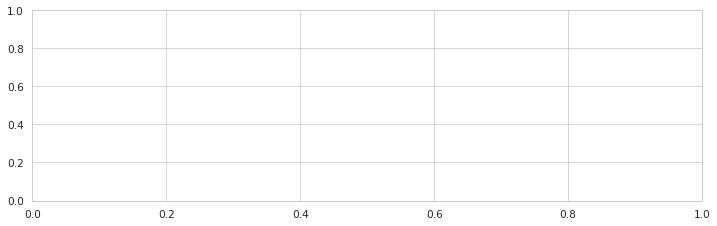

In [54]:
plt.figure(figsize=(12,3.5))
ax = sns.barplot(x=dataset_col_name, y=flips_col_name, hue=phrases_col_name, style=phrases_col_name, data=df, palette=sns.color_palette('tab10'))
plt.ylim(0,1)
plt.legend(title=phrases_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('output.png', bbox_inches='tight',dpi=300)
plt.close()

<Figure size 432x288 with 0 Axes>

In [31]:
zeros = [[ds, 0, 0] for ds, _ in flips_per_ds.items()]
data2 = data + zeros
df2 = pd.DataFrame(data2, columns=[dataset_col_name,phrases_col_name,flips_col_name])
df2.to_csv('data2.csv')

df2

,Dataset,Number of iterations,Percentage of decisions changed
0,imdb,1,0.528800
1,imdb,2,0.823800
2,imdb,3,0.942400
3,imdb,4,0.980600
4,imdb,5,0.992800
5,amazon,1,0.396667
6,amazon,2,0.656167
7,amazon,3,0.805667
8,amazon,4,0.892000
9,amazon,5,0.931167


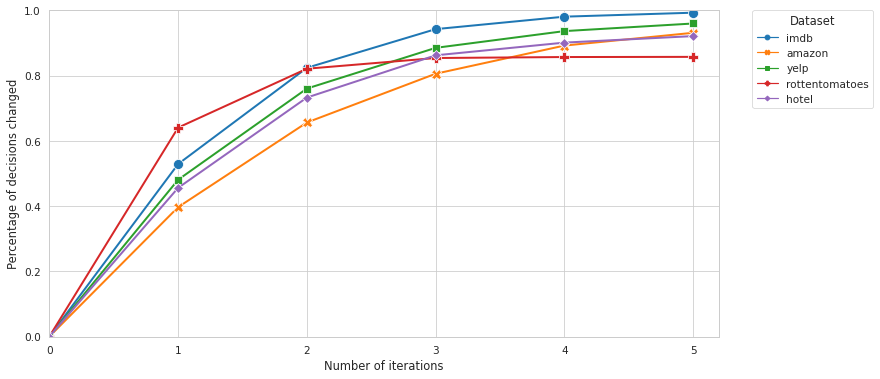

In [32]:

plt.figure(figsize=(12,6))
sns.lineplot(x=phrases_col_name, y=flips_col_name, hue=dataset_col_name, data=df2, markers=True,dashes=False, style=dataset_col_name, linewidth=2, markersize=10)
plt.ylim(0,1)
plt.xlim(0,5.2)
plt.legend(title=dataset_col_name, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


